# Outline of the Conversion Rates project
#### 1. Business objective
#### 2. EDA
#### 3. Logisitic Regression
#### 4. Decision Trees and Random Forest
#### 5. Recommendations using realistic business information

## 1. Business objective

#### The data is composed of information about users of a website (country, age, new_user boolean, source i.e. how they discovered the website, total pages visited on the website) and wether each user has subscribed to the newsletter or not ('converted').

#### We aim at providing two types of information for the persons running this website :
- the best possible model to predict wether a user is converted or not using every information available (see part 3 and 4)
- propose some recommendations in the perspective of targeting new users in order to maximize the probality of 'converting' them (i.e. find the most likely users to subscribe to the newsletter). (see part 5)

#### The main metric used to qualify the performance of our model will be the f1-score (harmonic mean of recall and precision) for class 1 :
#### f-1 score = 2 * Precision * Recall / (Precision + Recall)

## 2. Exploratory Data Analysis

In [16]:
# Importation and installation of useful librairies

In [1]:
!pip install plotly -q

In [2]:
!pip install imbalanced-learn

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_regression, f_classif

from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 2.1. Retrieve data, remove obvious outliers and compute basic statistics about the dataset

#### Note that the target variable is 'converted' : has the user subscribed to the newsletter or not ?

In [4]:
data = pd.read_csv('conversion_data_train.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [5]:
# We simply sort the columns to start with categorical variables (country, new_user, source) and end with quantitative variables (age, total_pages_visited)
data = data[['country','new_user','source','age','total_pages_visited','converted']]

In [6]:
# 284,580 observations in total
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   new_user             284580 non-null  int64 
 2   source               284580 non-null  object
 3   age                  284580 non-null  int64 
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [7]:
data.describe(include='all')

,country,new_user,source,age,total_pages_visited,converted
count,284580,284580.000000,284580,284580.000000,284580.000000,284580.000000
unique,4,NaN,3,NaN,NaN,NaN
top,US,NaN,Seo,NaN,NaN,NaN
freq,160124,NaN,139477,NaN,NaN,NaN
mean,NaN,0.685452,NaN,30.564203,4.873252,0.032258
std,NaN,0.464336,NaN,8.266789,3.341995,0.176685
min,NaN,0.000000,NaN,17.000000,1.000000,0.000000
25%,NaN,0.000000,NaN,24.000000,2.000000,0.000000
50%,NaN,1.000000,NaN,30.000000,4.000000,0.000000
75%,NaN,1.000000,NaN,36.000000,7.000000,0.000000


In [8]:
# We notice that the age of 2 users is not realistic and thus remove the corresponding observations.
data.loc[data['age']>90,:]

,country,new_user,source,age,total_pages_visited,converted
11331,UK,0,Ads,111,10,1
233196,Germany,0,Seo,123,15,1


In [9]:
data = data.loc[data['age']<90,:]
data.shape

(284578, 6)

### 2.2 Basic statistics in order to have a better understanding of the dataset

In [51]:
# let's see the proportion of 'converted' users ==> the dataset is clearly unbalanced (97% 0 and 3% 1).
print('the proportion of \'converted\' users in the dataset is : {:.1%}.'.format(data['converted'].sum()/data['converted'].shape[0]))

the proportion of 'converted' users in the dataset is : 3.2%.


In [52]:
# Let's see the distribution of converted users per country : users from China clearly appear to be reluctant to subscribe to the newsletter (0.1 of converted users !)
for country in data['country'].unique():
    data_country = data[data['country'] == country]
    print('\n**** ', country, ' ****')
    print('total users = {:,}'.format(data_country.shape[0]))
    print('relative importance of the country in the dataset = {:.1%}'.format(data_country.shape[0]/data.shape[0]))
    print('total converted users = {:,}'.format(data_country[data_country['converted']==1].shape[0]))
    print('total non converted users = {:,}'.format(data_country[data_country['converted']==0].shape[0]))
    print('proportion of converted users = {:.1%}'.format(data_country[data_country['converted']==1].shape[0]/data_country.shape[0],1))


****  China  ****
total users = 69,122
relative importance of the country in the dataset = 24.3%
total converted users = 89
total non converted users = 69,033
proportion of converted users = 0.1%

****  UK  ****
total users = 43,640
relative importance of the country in the dataset = 15.3%
total converted users = 2,290
total non converted users = 41,350
proportion of converted users = 5.2%

****  Germany  ****
total users = 11,692
relative importance of the country in the dataset = 4.1%
total converted users = 729
total non converted users = 10,963
proportion of converted users = 6.2%

****  US  ****
total users = 160,124
relative importance of the country in the dataset = 56.3%
total converted users = 6,070
total non converted users = 154,054
proportion of converted users = 3.8%


### 2.3 Data Visualizations on a sample (10,000 observations)

In [53]:
data_sample = data.sample(10000)

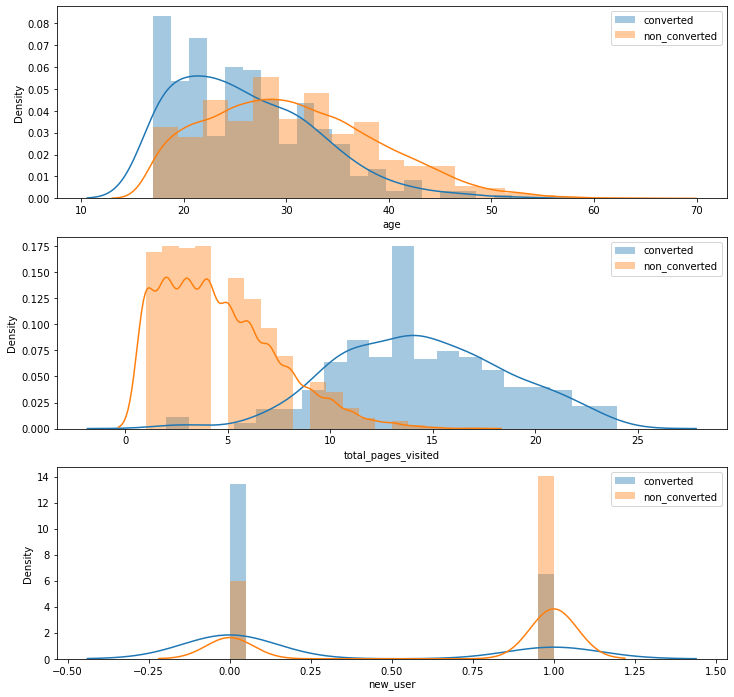

In [57]:
fig, axs = plt.subplots(3,1, figsize=(12,12))
sns.distplot(data_sample[data_sample['converted']==1]['age'], bins=20, kde=True, label='converted', ax=axs[0])
sns.distplot(data_sample[data_sample['converted']==0]['age'], bins=20, kde=True, label='non_converted', ax=axs[0])
axs[0].legend()

sns.distplot(data_sample[data_sample['converted']==1]['total_pages_visited'], bins=20, kde=True, label='converted', ax=axs[1])
sns.distplot(data_sample[data_sample['converted']==0]['total_pages_visited'], bins=20, kde=True, label='non_converted', ax=axs[1])
axs[1].legend()

sns.distplot(data_sample[data_sample['converted']==1]['new_user'], bins=20, kde=True, label='converted', ax=axs[2])
sns.distplot(data_sample[data_sample['converted']==0]['new_user'], bins=20, kde=True, label='non_converted', ax=axs[2])
axs[2].legend()

#### From the 3 graphs above, we can draw the main following observations :
- converted users appear to be younger on average than non-converted users (there is a important peak around 20 years-old) but the distributions overlaps a lot
- the variable 'total_pages_visited' can discriminate users that are 'converted' or not. As we could have expected, users who have visited the hight number of pages are more likely to subscribe (or to have already subscribed) to the newsletter.
- there are more 'converted' users among already registered users than among newly registered users : users do not automatically subscribe to the newsletter as they sign up to the website.

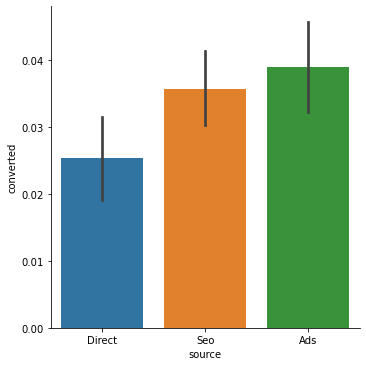

In [59]:
# Let's now figure out if the 'source' matters significantly
sns.catplot(x='source', y='converted', data=data_sample, kind="bar");
# ==> It appears from the graph below that the three sources are more or less equally represented among converted users.

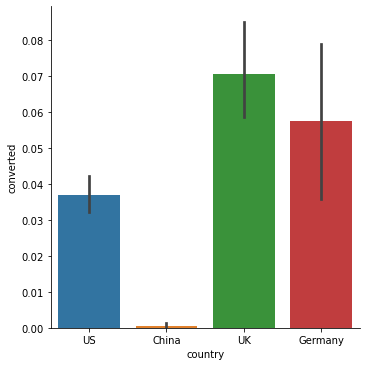

In [63]:
# Let's now figure out how the countries weigh for converted users.
sns.catplot(x='country', y='converted', data=data_sample, kind="bar");
# ==> As we saw above when computing basics statistics about the dataset, users from China are clearly less represented among converted users.

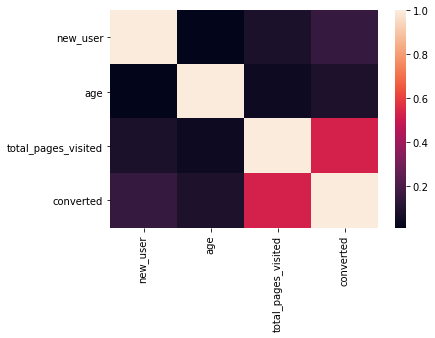

In [64]:
# Finally, let's take a look at the correlations between variables :
sns.heatmap(abs(data.corr()));
#==> We note that 'total_pages_visited' seems to be the only variable strongly correlated to the target variable 'converted'.

#### We can confirme this final observation by plotting the target variable ('converted') regarding only the 'total_visited_pages' variable and trying to automatically fit a logistic regression on the graph.

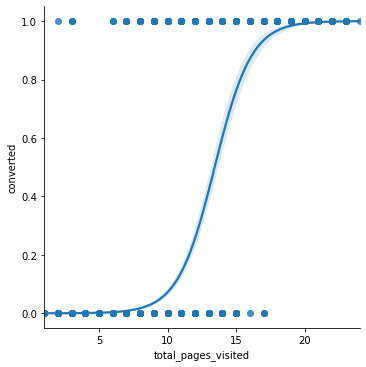

In [65]:
sns.lmplot(x='total_pages_visited', y='converted', data=data_sample, logistic=True);

## 3. Logistic Regression

### 3.1 Feature selection

#### First, let's perform a feature selection. We analyse the importance of each variable in the dataset using scikit-learn f_classif function (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html)

In [70]:
data.columns

Index(['country', 'new_user', 'source', 'age', 'total_pages_visited',
       'converted'],
      dtype='object')

In [72]:
# Preprocessing, note that we do not need an imputer since no information is missing.
X = data.drop('converted', axis=1)
y = data['converted']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating colinearity between features
    ])

# we use ColumnTranformer to build a preprocessor object that wraps all the treatments to be done on the variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [3,4]),
        ('cat', categorical_transformer, [0,1,2])     
    ])

X = preprocessor.fit_transform(X)

# Retrieve name of the features
features = list(preprocessor.transformers_[1][1]['encoder'].get_feature_names())
features.extend(['age','total_pages_visited'])

feature_analysis = pd.DataFrame(columns=['F score','p-value'],
                                data=np.array(f_classif(X, y)).T,
                                index=features)
display(feature_analysis.sort_values(by='F score', ascending=False))

,F score,p-value
x0_UK,110680.382032,0.000000e+00
x2_Seo,6737.133487,0.000000e+00
x0_Germany,2257.286255,0.000000e+00
x1_1,677.039999,4.403019e-149
x2_Direct,375.889602,1.106670e-83
x0_US,354.358494,5.323175e-79
age,53.242044,2.956420e-13
total_pages_visited,3.310654,6.883313e-02


#### The correspondance between variables and encoded variables is as follows:
- x0_ : country
- x1_ : new_user (boolean)
- x2_ : source

#### Surprisingly considering the observations raised during the EDA (see part 2), the variable 'total_pages_visited' has the lowest F-score and highest p-value. Nevertheless, we decide to keep it as the p-value is not extrememy high (6.88%).

#### Now, let's find out how a logistic regression models perform on our dataset.

### 3.2 Preprocessing

In [208]:
# Preprocessing
# The 'stratify' argument is extremely important here because our dataset is very unbalanced (97/3)
X_train, X_test, y_train, y_test = train_test_split(data.drop('converted', axis=1), data['converted'],
                                                    test_size=0.2, random_state=0, stratify=data['converted'])

In [209]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [3,4]),
        ('cat', categorical_transformer, [0,1,2])     
    ])

# Preprocessing on train set
X_train = preprocessor.fit_transform(X_train)

# Preprocessing on test set
X_test = preprocessor.transform(X_test)

### 3.3 Fitting of a logistic regression

In [143]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

print("f1-score on train set : {:.4}".format(f1_score(y_train, y_train_pred)))
print("f1-score on test set : {:.4}".format(f1_score(y_test, y_test_pred)))

f1-score on train set : 0.7637
f1-score on test set : 0.7646


In [152]:
# Let's try to confirm this result with a cross validation
classifier_cv = LogisticRegression()
all_scores = cross_validate(classifier_cv, X_train, y_train, cv=10, scoring=('accuracy', 'f1'), return_train_score=True)
print('*** Train ***')
print("Cross-validated mean accuracy score : {:.4}\nStd of accuracy: {:.4}".format(all_scores['train_accuracy'].mean(), all_scores['train_accuracy'].std()))
print("Cross-validated mean f-1 score : {:.4}\nStd of f1-scores: {:.4}".format(all_scores['train_f1'].mean(), all_scores['train_f1'].std()))
print('\n*** Test ***')
print("Cross-validated mean accuracy score : {:.4}\nStd of accuracy: {:.4}".format(all_scores['test_accuracy'].mean(), all_scores['test_accuracy'].std()))
print("Cross-validated mean f-1 score : {:.4}\nStd of f1-scores: {:.4}".format(all_scores['test_f1'].mean(), all_scores['test_f1'].std()))

*** Train ***
Cross-validated mean accuracy score : 0.9862
Std of accuracy: 9.426e-05
Cross-validated mean f-1 score : 0.7636
Std of f1-scores: 0.001916

*** Test ***
Cross-validated mean accuracy score : 0.9862
Std of accuracy: 0.0007593
Cross-validated mean f-1 score : 0.7634
Std of f1-scores: 0.0135


#### These results show that there is no obvious overfitting of the model : the performance on train and test dataset are very close (the average f1-score for a regular logistic regression is 0.76). Let's now perform an error analysis to determine how this score could be improved even though the fact that train and test scores are so close indicates that it might be hard to improve our objective score.

### 3.3 Analysis of the results

In [153]:
# Computation of the confusion matrices and classification reports for train and test datasets.
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

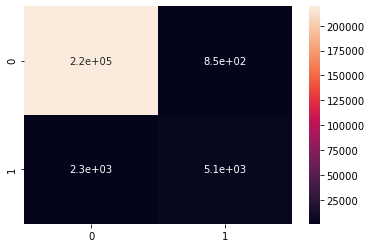

In [154]:
sns.heatmap(cm_train, annot=True);

In [102]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.86      0.69      0.76      7342

    accuracy                           0.99    227662
   macro avg       0.92      0.84      0.88    227662
weighted avg       0.99      0.99      0.99    227662



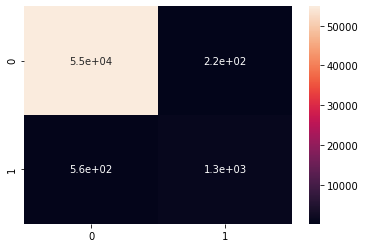

In [103]:
sns.heatmap(cm_test, annot=True);

In [156]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.85      0.69      0.76      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.85      0.88     56916
weighted avg       0.99      0.99      0.99     56916



In [104]:
# Visualize ROC curves
probas_train = classifier.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(Y_train, probas_train)
fig = go.Figure(
    data = go.Scatter(
        name = 'train',
        x = fpr, 
        y = tpr, 
        mode = 'lines'
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "ROC curve", x = 0.5),
        xaxis = go.layout.XAxis(title = 'False Positive Rate'),
        yaxis = go.layout.YAxis(title = 'True Positive Rate')
    )
)

probas_test = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, probas_test)
fig.add_trace(go.Scatter(
    name = 'test',
    x = fpr, 
    y = tpr, 
    mode = 'lines'
    )
)
fig.show()

#### The shapes of the ROC curves look convincing (the curves are far from the diagonal) but considering the confusion matrix on the test dataset, it seems that we have a lot of False Negatives in our predictions. Indeed, the recall is only at 0.69 indicating that the model was able to predict only 69% 'converted' users among all converted users in the test set. Improving this result could have a strong positive on our f1-score, we basically want to transform False Negatives (FN) into True Positive (TP). We will try to determine what distinguish FN to TP in order to improve our model.

In [133]:
X_train_error_analysis, X_test_error_analysis, y_train_error_analysis, y_test_error_analysis = train_test_split(data.drop('converted', axis=1), 
                                                                                                                data['converted'], test_size=0.2, 
                                                                                                                random_state=0, stratify=data['converted'])

FN = X_test_error_analysis[(y_test_pred == 0) &(y_test == 1)]
TP = X_test_error_analysis[(y_test_pred == 1) &(y_test == 1)]

In [134]:
# Sanity check : verify that the FN and TP quantities correspond to the confusion matrix calculated on the test set :
print('we found {:,} False negatives, it matches the confusion matrix calculated above : {}.'.format(FN.shape[0], FN.shape[0]==cm_test[1,0]))
print('we found {:,} True positives, it matches the confusion matrix calculated above : {}.'.format(TP.shape[0], TP.shape[0]==cm_test[1,1]))

we found 561 False negatives, it matches the confusion matrix calculated above : True.
we found 1,275 True positives, it matches the confusion matrix calculated above : True.


In [135]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1, subplot_titles=("Country","Source", "Age", "Total_pages_visited"))

fig.add_trace(go.Bar(x=np.unique(FN['country']), 
                     y=FN.value_counts('country').values/FN.shape[0], name='FN'),
              1, 1)
fig.add_trace(go.Bar(x=np.unique(FN['country']), y=TP.value_counts('country').values/TP.shape[0], name='TP'),
              1, 1)

fig.add_trace(go.Bar(x=np.unique(FN['source']), y=FN.value_counts('source').values/FN.shape[0], name='FN'),
              2, 1)
fig.add_trace(go.Bar(x=np.unique(FN['source']), y=TP.value_counts('source').values/TP.shape[0], name='TP'),
              2, 1)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=True, title_text="Comparison of False Negatives and True Positives")
fig.show()

#### Regarding the variables 'country' and 'source', the data seems actually very similar between FN and TP. It seems difficult to find a way to discriminate them in order to reduce the FN population.

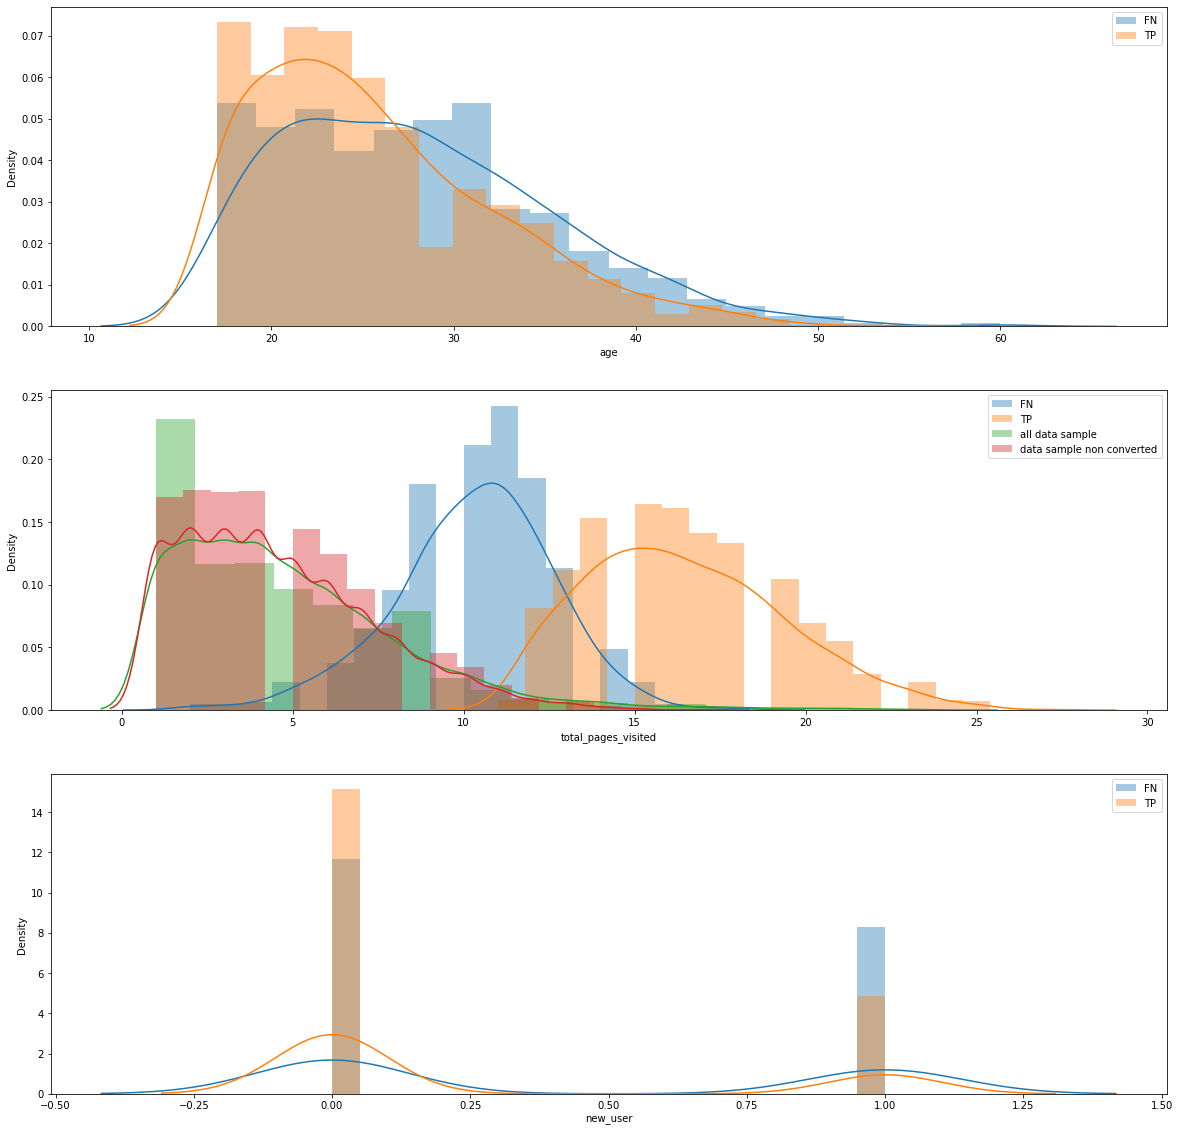

In [136]:
fig, axs = plt.subplots(3,1, figsize=(20,20))

sns.distplot(FN['age'], bins=20, kde=True, label='FN', ax=axs[0])
sns.distplot(TP['age'], bins=20, kde=True, label='TP', ax=axs[0])
axs[0].legend()

sns.distplot(FN['total_pages_visited'], bins=20, kde=True, label='FN', ax=axs[1])
sns.distplot(TP['total_pages_visited'], bins=20, kde=True, label='TP', ax=axs[1])
sns.distplot(data_sample['total_pages_visited'], bins=20, kde=True, label='all data sample', ax=axs[1])
sns.distplot(data_sample[data_sample['converted']==0]['total_pages_visited'], bins=20, kde=True, label='data sample non converted', ax=axs[1])
axs[1].legend()

sns.distplot(FN['new_user'], bins=20, kde=True, label='FN', ax=axs[2])
sns.distplot(TP['new_user'], bins=20, kde=True, label='TP', ax=axs[2])
axs[2].legend()

#### It looks like the distribution of the variables 'age' and 'total pages visited' are quite similare between FN and a part of TP. The average number of pages visited is a bit lower for FN than for TP, so this might be a good insigth to exploit but it may difficult to increase a lot the f1-score.

### 3.4 Optimization of the parameters of the logistic regression

#### 3.4.1 Probability threshold
#### Let's try to see if the probability threshold associated to the decision can be modified to increase the F1-score 

Best probability threshold = 41.0%, maximized f1-score=0.7652
To be compared to the f1-score with default threshold (50%) = 0.7236


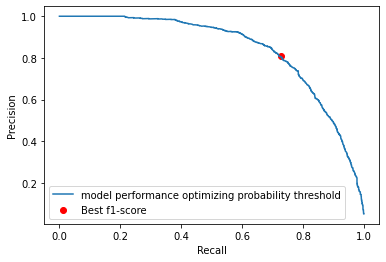

In [210]:
# predict probabilities, and keep only the class = 1
probas_test = classifier.predict_proba(X_test)[:,1]

# Computation of precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, probas_test)

# computation of to f1-score
f1score = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
idx = np.argmax(f1score)
print('Best probability threshold = {:.1%}, maximized f1-score={:.4}'.format(thresholds[idx], f1score[idx]))
print('To be compared to the f1-score with default threshold (50%) = {:.4}'.format(f1_score(y_test, y_test_pred)))


plt.plot(recall, precision, label='model performance optimizing probability threshold')
plt.scatter(recall[idx], precision[idx], marker='o', color='red', label='Best f1-score')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#### By switching the probability threshold from 50% to 41%, we only very slighly improve the performance of the logistic regression.

#### 3.4.1 Class weights
#### Let's now try to see if the weights associated to  each class by the model can be fine-tuned to increase the F1-score 

In [ ]:
weights_classifier = LogisticRegression()
weights = np.linspace(0.0,0.97,100)
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}
grid_weights = GridSearchCV(weights_classifier, param_grid=param_grid, cv=10, verbose=0, scoring='f1')
grid_weights.fit(X_train, y_train)
y_test_pred = grid_weights.predict(X_test)

In [212]:
print('Best weights:', grid_weights.best_estimator_.get_params()['class_weight'])
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Best weights: {0: 0.4017171717171717, 1: 0.5982828282828283}
f1-score on test set :  0.7646723646723647
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     55080
           1       0.80      0.73      0.76      1836

    accuracy                           0.99     56916
   macro avg       0.90      0.86      0.88     56916
weighted avg       0.98      0.99      0.99     56916



#### We obtained the same perfomance (f1 of 0.7647) and the best weights identified are {0: 0.40, 1: 0.60}. It is though interesting to note that in comparison to the initial model, we have a better recall (0.73 vs 0.69) but a worst precision (0.80 vs 0.85).

#### Finally, by optimizing the probability threshold and the class weights, we didn't manage to improve the f1-score of our model. We will now try other classification models : decision trees and randown forests.

## 4. Decision tree and random forest

### 4.1 Decision tree

#### A decision tree permits to characterize the space defined by the explanatory variables as a grid. By contruction, it can exploit any non-linear relationships between variables that could lead to better prediction performances.

In [214]:
# preprocessing : it is not necessary to scale the quantitative variables for the fitting of a tree :
# The 'stratify' argument is extremely important here because our dataset is very unbalanced (97/3)
X_train, X_test, y_train, y_test = train_test_split(data.drop('converted', axis=1), data['converted'],
                                                    test_size=0.2, random_state=0, stratify=data['converted'])

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

numeric_transformer = Pipeline(steps=[
    ('passthrough', 'passthrough' )
])
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [3,4]),
        ('cat', categorical_transformer, [0,1,2])     
    ])

# Preprocessing on train set
X_train = preprocessor.fit_transform(X_train)
# Preprocessing on test set
X_test = preprocessor.transform(X_test)

In [215]:
# Let's find out how a regular tree performs before tuning its hyper-parameters.
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train,y_train)
y_train_pred = tree_classifier.predict(X_train)
y_test_pred = tree_classifier.predict(X_test)

print("accuracy on training set : {:.4}".format(accuracy_score(y_train, y_train_pred)))
print("accuracy on test set : {:.4}".format(accuracy_score(y_test, y_test_pred)))
print("f1-score on train set : {:.4}".format(f1_score(y_train, y_train_pred)))
print("f1-score on test set : {:.4}".format(f1_score(y_test, y_test_pred)))

accuracy on training set : 0.9885
accuracy on test set : 0.984
f1-score on train set : 0.8012
f1-score on test set : 0.7233


#### We can see here that the model overfits : the performance are much better on the train set than on the test set. Using a grid search, we can tune the hyper-parameters of the model and improve its performance.

In [205]:
%%time
tree_classifier_GS = DecisionTreeClassifier()
params = {'max_depth' : [2,5,10,15],
         'min_samples_split' : [2,5,10],
         'min_samples_leaf' : [2,5,8,10]}

grid = GridSearchCV(estimator=tree_classifier_GS, param_grid=params, cv=5, scoring="f1")
grid.fit(X_train, y_train)
grid.best_params_

CPU times: user 1min 3s, sys: 23 ms, total: 1min 3s
Wall time: 1min 3s


{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}

In [216]:
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

print("accuracy on training set : {:.4}".format(accuracy_score(y_train, y_train_pred)))
print("accuracy on test set : {:.4}".format(accuracy_score(y_test, y_test_pred)))
print("f1-score on train set : {:.4}".format(f1_score(y_train, y_train_pred)))
print("f1-score on test set : {:.4}".format(f1_score(y_test, y_test_pred)))

accuracy on training set : 0.9867
accuracy on test set : 0.9852
f1-score on train set : 0.7712
f1-score on test set : 0.7453


#### Thanks to the grid search performed, we improved the performances of the model on test data and reduced the overfitting but so far, the f1-score is actually lower than the ones we obtained with a logistic regression model.

### 4.2 Random forest

#### Using the principal of bagging (bootstrap + aggregating ), a random forest can help us exploiting in a more efficient way the information contained in our dataset. Even if we don't have a lot of variables, the dataset is quite large (almost 300 k observations) and we saw earlier how difficult it was to detect fundamental differences between the profiles of the True Positives and False Negatives in our predictions. Let's see in a random forest helps us improving our result.

In [223]:
%%time
param = {"n_estimators": [50,100,200],
        "max_depth": [5,10],
        "min_samples_split": [2,5]}
rf_classifier = RandomForestClassifier()

grid = GridSearchCV(rf_classifier, param_grid=param, scoring = "f1")
grid.fit(X_train,y_train)

y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

print("accuracy on training set : {:.4}".format(accuracy_score(y_train, y_train_pred)))
print("accuracy on test set : {:.4}".format(accuracy_score(y_test, y_test_pred)))
print("f1-score on train set : {:.4}".format(f1_score(y_train, y_train_pred)))
print("f1-score on test set : {:.4}".format(f1_score(y_test, y_test_pred)))

accuracy on training set : 0.9873
accuracy on test set : 0.9853
f1-score on train set : 0.7819
f1-score on test set : 0.7488
CPU times: user 7min 18s, sys: 632 ms, total: 7min 19s
Wall time: 7min 19s


In [225]:
print(grid.best_params_)

{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}


#### By trying many other parameters in the grid search performed, we should be able to determine a Random Forest Classifier which does not overfit. Anyway, the f1-score of the model on test data we obtained so far is actually lower than the one we obtained with a logistic regression model. For this reason and because of the complexity of a random forest model compared to a logistic regression, we decide not to go further in this direction.

## 4.3 Conclusion for our first business objective
#### The first objective was to *develop the best possible model to predict wether a user is converted or not using every information available*.
#### After using several techniques in order to optimize the performance of our first logistic regression model (error analysis, optimization of probability threshold, optimization of class weights) and trying to use other models as Decision Tree and Random Forest, we didn't improve the performance of the simplest model : the regular logistic regression (f1-score of 0.76).
#### Since this model is the simplest we developped and presents decent performances, our recommendation is to use this one.
#### In the future, it might be interesting to try other models such as SVM and some boosting techniques (AdaBoost for example).

## 5. Recommendations using realistic business information

#### The objective of this last section is to propose some recommendations in the perspective of targeting new users in order to maximize the probality of 'converting' them (i.e. find the most likely users to subscribe to the newsletter).
#### Thus, we will not used all available data but we will instead remove the 'total_pages_visited' variable considering that it would not be possible to improve this lever when targetting potential users.

#### 5.1 Let's see the feature importance of this dataset

In [229]:
data.columns

Index(['country', 'new_user', 'source', 'age', 'total_pages_visited',
       'converted'],
      dtype='object')

In [230]:
# Preprocessing, note that we do not need an imputer since no information is missing.
X = data.drop(['converted', 'total_pages_visited'], axis=1)
y = data['converted']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating colinearity between features
    ])

# we use ColumnTranformer to build a preprocessor object that wraps all the treatments to be done on the variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [3]),
        ('cat', categorical_transformer, [0,1,2])     
    ])

X = preprocessor.fit_transform(X)

# Retrieve name of the features
features = list(preprocessor.transformers_[1][1]['encoder'].get_feature_names())
features.extend(['age'])

feature_analysis = pd.DataFrame(columns=['F score','p-value'],
                                data=np.array(f_classif(X, y)).T,
                                index=features)
display(feature_analysis.sort_values(by='F score', ascending=False))

,F score,p-value
x2_Direct,6737.133487,0.000000e+00
x0_Germany,2257.286255,0.000000e+00
x0_US,677.039999,4.403019e-149
x1_1,375.889602,1.106670e-83
x0_UK,354.358494,5.323175e-79
x2_Seo,53.242044,2.956420e-13
age,3.310654,6.883313e-02


#### *Recommendation*
#### It appears clearly that the most important factors to target are the 'direct' source and the country 'Germany'. Hence, in order to imporve to conversion rate of this website, we can recommend to encourage all converted users from Germany to explain to their colleagues/friends/relatives interested in data science how satisfied they are with the newsletter.

#### 5.2 Let's see how a logistic regression performs on the dataset without the 'total_pages_visited'

In [239]:
# Preprocessing
# The 'stratify' argument is extremely important here because our dataset is very unbalanced (97/3)
X_train, X_test, y_train, y_test = train_test_split(data.drop(['converted', 'total_pages_visited'], axis=1), data['converted'],
                                                    test_size=0.2, random_state=0, stratify=data['converted'])

In [240]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [3]),
        ('cat', categorical_transformer, [0,1,2])     
    ])

# Preprocessing on train set
X_train = preprocessor.fit_transform(X_train)
# Preprocessing on test set
X_test = preprocessor.transform(X_test)

In [242]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

print("f1-score on train set : {:.4}".format(f1_score(y_train, y_train_pred)))
print("f1-score on test set : {:.4}".format(f1_score(y_test, y_test_pred)))
print(classification_report(y_test, y_test_pred))

f1-score on train set : 0.0
f1-score on test set : 0.0
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     55080
           1       0.00      0.00      0.00      1836

    accuracy                           0.97     56916
   macro avg       0.48      0.50      0.49     56916
weighted avg       0.94      0.97      0.95     56916



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#### Without the variable 'total_pages_visited', our model completely fails to predict users that could be converted. We can correct this by using several techniques (probability threshold optimisation for example) and for this part, we will use under_sampling.
#### The principal is to determine the best sampling strategy (number of 'non_converted' users versus number of 'converted' users) in order to maximise the performances of our model. To do so, we use the 'imbalanced-learn' library and tries many sampling strategy (following the principal of a grid search).

In [28]:
f1_train = []
f1_test = []
X = data.drop(['converted','total_pages_visited'], axis=1)
y = data['converted']

for i in range(4,75):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    total_converted = y_train.sum()
    
    # We set the under_sampler strategy based on the converted population and by imposing to have a population of non_converted equals to (100/i * converted)
    under_sampler = RandomUnderSampler(sampling_strategy={0:int(total_converted/(i/100)), 1:total_converted})

    # fit the object to the training data.
    X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

    X_train_under = X_train_under.values
    X_test = X_test.values
    y_test = y_test.values
    y_train_under = y_train_under.values

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(
        steps=[
        ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
        ])

    # Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, [3]),
            ('cat', categorical_transformer, [0,1,2])     
        ])

    # Preprocessings on train set
    X_train_under = preprocessor.fit_transform(X_train_under)
    # Preprocessings on test set
    X_test = preprocessor.transform(X_test)

    classifier = LogisticRegression()
    classifier.fit(X_train_under, y_train_under)

    y_train_pred = classifier.predict(X_train_under)
    y_test_pred = classifier.predict(X_test)
    
    f1_train.append(f1_score(y_train_under, y_train_pred))
    f1_test.append(f1_score(y_test, y_test_pred))

#### Finally, without the 'total_pages_visited', we manage to reach a f1-score of 0.22 thanks to the relevant under_sampling strategy :

In [34]:
print('The best f1-score on train data is {:.4}.'.format(np.max(f1_train)))
print('The best f1-score on test data is {:.4}.'.format(np.max(f1_test)))
print('It has been obtained with the following under_sampling strategy : {:d} \'converted\' users and {:d} \'non_converted\' users.'.format(total_converted, int(100*total_converted/(np.argmax(f1_test)+4))))

The best f1-score on train data is 0.6936.
The best f1-score on test data is 0.2183.
It has been obtained with the following under_sampling strategy : 7342 'converted' users and 23683 'non_converted' users.
